In [1]:
!pip install monashspa[PHS3302]

In [2]:
# # A demonstration of using a neural network to obtain a cleaner sample of $B^0 \to K^{*0}\mu^+\mu^-$ decays
#############################################################################################################

# The data files below should be copied into the same folder as where this file is located.
#
# simulation.h5 : Contains simulated events of the decay
# data.h5 : Contains events from the LHCb detector in 2016
# data-uppersideband.h5 : Events from the upper sideband of the data

import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import BatchNormalization
from monashspa.PHS3302.selection.frame import getframe
from lmfit import minimize, Parameters, fit_report

# Some helper functions

def stack(frame, column_names):
    arrays = [frame[name] for name in column_names]
    return np.stack(arrays, axis=1)

The data set contains the variables:
B0_DiraAngle
B0_ENDVERTEX_CHI2
B0_ENDVERTEX_NDOF
B0_OWNPV_X
B0_OWNPV_Y
B0_OWNPV_Z
B0_IPCHI2_OWNPV
B0_FDCHI2_OWNPV
B0_DIRA_OWNPV
B0_P
B0_PT
B0_MM
B0_BKGCAT
B0_TRUEID
B0_TAU
B0_relinfo_MU_SLL_ISO_1
B0_relinfo_MU_SLL_ISO_2
J_psi_ENDVERTEX_CHI2
J_psi_IPCHI2_OWNPV
J_psi_FDCHI2_OWNPV
J_psi_M
mu_plus_IPCHI2_OWNPV
mu_plus_P
mu_plus_PT
mu_plus_PIDmu
mu_plus_PIDK
mu_plus_PIDp
mu_plus_TRACK_GhostProb
mu_minus_P
mu_minus_PT
mu_minus_PIDmu
mu_minus_PIDK
mu_minus_PIDp
mu_minus_TRACK_GhostProb
K_P
K_PT
K_PIDmu
K_PIDK
K_PIDp
K_TRACK_GhostProb
Pi_P
Pi_PT
Pi_PIDmu
Pi_PIDK
Pi_PIDp
Pi_TRACK_GhostProb
nCandidate
runNumber
eventNumber
weight_PHSP_FSR
weight_FLATQ2_FSR
BDT

The BDT variable is the output of a Boosted Decision Tree which is another type of machine learning algorithm.




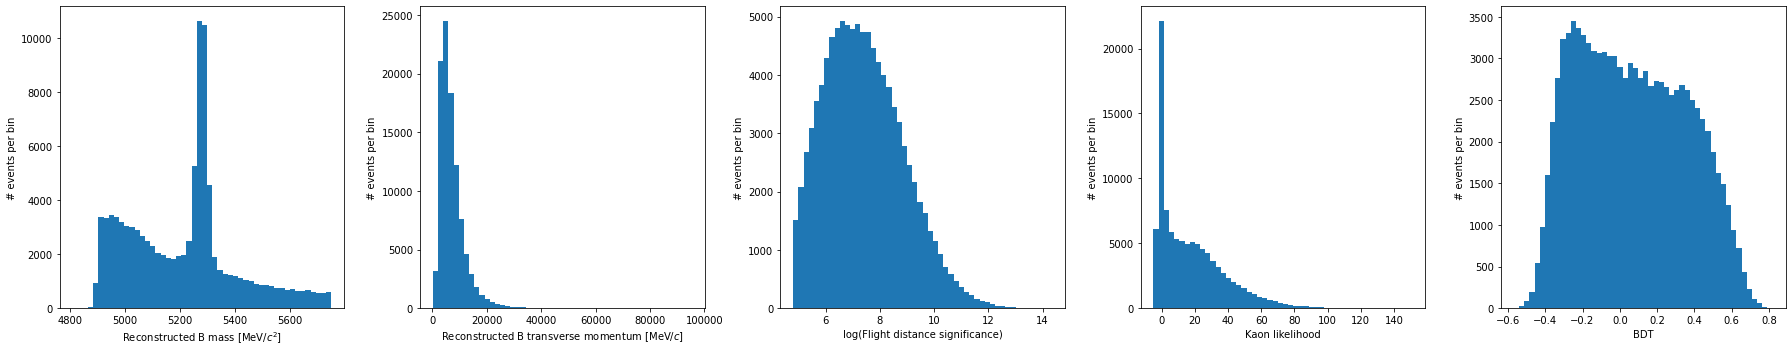

In [3]:
# ## Illustrate the variables in the data and plot a few
########################################################

signalregion_frame = getframe("data.h5")

# Show what is inside the dataset
print("="*50)
print("The data set contains the variables:")
for var in signalregion_frame.dtype.fields:
    print(var)

print("\nThe BDT variable is the output of a Boosted Decision Tree which is another type of machine learning algorithm.\n\n")
print("="*50)

fig = plt.figure(figsize=(25,5))
ax1, ax2, ax3, ax4, ax5 = fig.subplots(1, 5)

ax1.hist(signalregion_frame['B0_MM'], 50)
ax1.set_xlabel(r'Reconstructed B mass [MeV/$c^2$]')
ax1.set_ylabel(r'# events per bin')

ax2.hist(signalregion_frame['B0_PT'], 50)
ax2.set_xlabel(r'Reconstructed B transverse momentum [MeV/$c$]')
ax2.set_ylabel(r'# events per bin')

ax3.hist(np.log(signalregion_frame['B0_FDCHI2_OWNPV']), 50)
ax3.set_xlabel(r'log(Flight distance significance)')
ax3.set_ylabel(r'# events per bin')

ax4.hist(signalregion_frame['K_PIDK'], 50)
ax4.set_xlabel(r'Kaon likelihood')
ax4.set_ylabel(r'# events per bin')

ax5.hist(signalregion_frame['BDT'], 50)
ax5.set_xlabel(r'BDT')
ax5.set_ylabel(r'# events per bin')

plt.tight_layout()

In [4]:
# ## Setup a neural network using the Keras framework
#####################################################

# Prepare the data
vars = ['B0_DiraAngle', 'B0_ENDVERTEX_CHI2', 'mu_minus_PT', 'mu_plus_PT', 'K_PT', 'Pi_PT', 'B0_FDCHI2_OWNPV', 'B0_relinfo_MU_SLL_ISO_1', 'B0_IPCHI2_OWNPV']

uppersideband = stack(getframe("data-uppersideband.h5"), vars)
simulation = stack(getframe("simulation.h5"), vars)
n_uppersideband = uppersideband.shape[0]
n_simulation = simulation.shape[0]

# Label the background as 0 and the simulated signal as 1
uppersideband_labels = np.zeros(n_uppersideband)
simulation_labels = np.ones(n_simulation)

# Put it all together and create a training dataset and a testing dataset. Use 80% for training
n_uppersideband_split = int(0.8*n_uppersideband)
n_simulation_split = int(0.8*n_simulation)
trainingdata = np.concatenate((uppersideband[:n_uppersideband_split], simulation[:n_simulation_split]))
traininglabels = np.concatenate((uppersideband_labels[:n_uppersideband_split], simulation_labels[:n_simulation_split]))

testingdata = np.concatenate((uppersideband[n_uppersideband_split:], simulation[n_simulation_split:]))
testinglabels = np.concatenate((uppersideband_labels[n_uppersideband_split:], simulation_labels[n_simulation_split:]))

# Instantiate model
model = Sequential()

# The input layer
model.add(Dense(16, input_dim=trainingdata.shape[1]))
model.add(BatchNormalization())
model.add(Activation('relu'))

# A hidden layer
model.add(Dense(8, activation = 'relu'))

# The output layer
model.add(Dense(1, activation = 'sigmoid'))

# Build as a binary classification
model.compile(optimizer='rmsprop',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model, iterating on the data in batches of 32 samples
model.fit(trainingdata, traininglabels, epochs=10, batch_size=32, verbose=0)

2021-08-11 12:25:40.792781: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2021-08-11 12:25:40.792800: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)
2021-08-11 12:25:40.792846: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (laptop): /proc/driver/nvidia/version does not exist
2021-08-11 12:25:40.792957: I tensorflow/core/platform/cpu_feature_guard.cc:143] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2021-08-11 12:25:40.808604: I tensorflow/core/platform/profile_utils/cpu_utils.cc:102] CPU Frequency: 1899950000 Hz
2021-08-11 12:25:40.808897: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fad4c000b60 initialized for platform Host (this does not guarantee that XLA

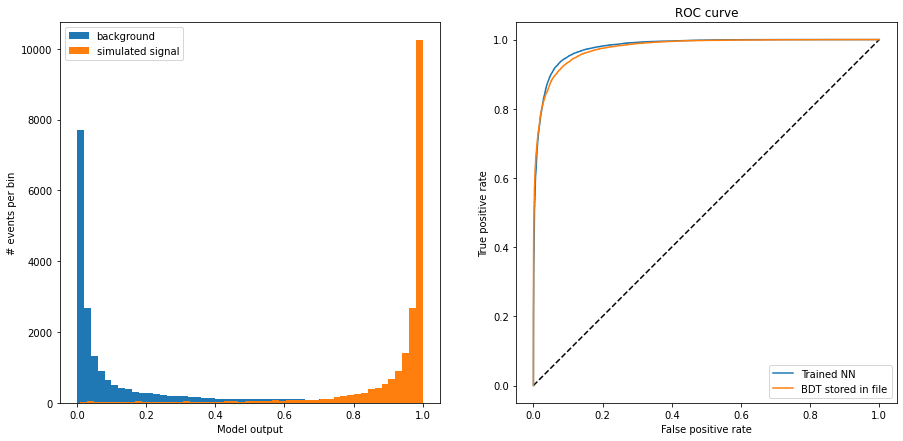

In [5]:
# ## Use the trained model to validate on testing data and make prediction
##########################################################################

# Evaluate model on on testing data and on the signal region
bkgoutput = model.predict(uppersideband[n_uppersideband_split:])
simoutput = model.predict(simulation[n_simulation_split:])
testingoutput = model.predict(testingdata)

signalregion = stack(signalregion_frame, vars)
sigoutput = model.predict(signalregion)

# Create some nice plots
fig = plt.figure(figsize=(15,7))
ax1, ax2 = fig.subplots(1, 2)
ax1.hist(bkgoutput, 50, label='background')
ax1.hist(simoutput, 50, label='simulated signal')
ax1.legend()
ax1.set_xlabel(r'Model output')
ax1.set_ylabel(r'# events per bin')

# Create a ROC
from sklearn.metrics import roc_curve, auc

fpr_keras, tpr_keras, thresholds_keras = roc_curve(testinglabels, testingoutput)
auc_keras = auc(fpr_keras, tpr_keras)

uppersidebandbdt = getframe("data-uppersideband.h5")['BDT'][n_uppersideband_split:]
simulationbdt = getframe("simulation.h5")['BDT'][n_simulation_split:]
bdttestingoutput = np.concatenate((uppersidebandbdt, simulationbdt))
fpr_BDT, tpr_BDT, thresholds_BDT = roc_curve(testinglabels, bdttestingoutput)
auc_BDT = auc(fpr_BDT, tpr_BDT)

ax2.plot([0, 1], [0, 1], 'k--')
ax2.plot(fpr_keras, tpr_keras, label='Trained NN')
ax2.plot(fpr_BDT, tpr_BDT, label='BDT stored in file')
ax2.set_xlabel('False positive rate')
ax2.set_ylabel('True positive rate')
ax2.set_title('ROC curve')
ax2.legend(loc='best')


Fit model: a*exp(-k*(m-m0)) + norm*exp(-(m-m0)^2/width^2)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 36
    # data points      = 130
    # variables        = 4
    chi-square         = 490.441983
    reduced chi-square = 3.89239669
    Akaike info crit   = 180.610430
    Bayesian info crit = 192.080568
[[Variables]]
    a:      67.6976005 +/- 1.95663317 (2.89%) (init = 142)
    k:      0.00492790 +/- 1.6399e-04 (3.33%) (init = 0.002)
    mean:   5280 (fixed)
    width:  18.8747084 +/- 0.22403860 (1.19%) (init = 20)
    norm:   2224.87945 +/- 38.3255522 (1.72%) (init = 710)
[[Correlations]] (unreported correlations are < 0.100)
    C(width, norm) = -0.605
    C(a, width)    = -0.179
The fit gives 22417 signal events


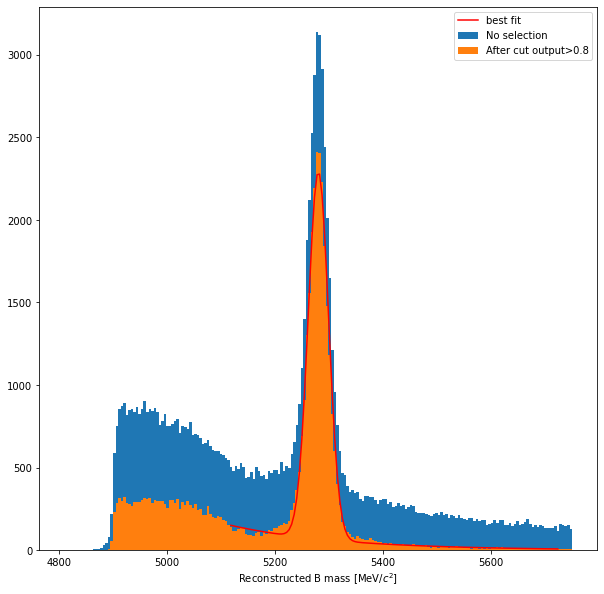

In [6]:
# Let us reject anything with a value below 0.8 and see how it affects the signal mass peak. 
# Then make a fit to the distribution

fig = plt.figure(figsize=(10,10))
ax3 = fig.subplots(1, 1)
mask = (sigoutput < 0.8)
mass = signalregion_frame['B0_MM']
maskedmass = np.ma.masked_array(mass, mask)
ax3.hist(mass, 200, label='No selection')
entries, bins, _ = ax3.hist(maskedmass[~maskedmass.mask], 200, label='After cut output>0.8')

# Define a fit model

def model(params, x):
    """This model is using an exponential for the background and a Gaussian 
    for the signal.
    """
    a = params['a']
    k = params['k']
    mean = params['mean']
    width = params['width']
    norm = params['norm']
    
    delta = x-mean
    return a*np.exp(-k*delta) + norm*np.exp(-delta*delta/(2*width*width))

def residual(params, x, data, eps_data):
    res = (data-model(params,x)) / eps_data
    return res

#Perform fit
minbin = 65
maxbin = 195

counts = entries[minbin:maxbin]
u_counts = np.sqrt(counts)
massbins = bins[minbin:maxbin] + (bins[1]-bins[0])/2.

params = Parameters()
params.add('a', value=counts[0])
params.add('k', value=1/500.)
params.add('mean', value=5280.0, vary=False)
params.add('width', value=20.0, vary=True)
params.add('norm', value=5*counts[0], vary=True)

out = minimize(residual, params, args=(massbins, counts, u_counts))

print('='*50)
print('Fit model: a*exp(-k*(m-m0)) + norm*exp(-(m-m0)^2/width^2)')
print(fit_report(out))

best_fit = model(out.params,massbins)

signal_params = out.params.copy()
signal_params['a'].value = 0
signal = model(signal_params,massbins)
n_signal_events = sum(signal)
print(f'The fit gives {n_signal_events:.0f} signal events')
print('='*50)


ax3.plot(massbins, best_fit, marker="None", linestyle="-", color="red",label="best fit")

ax3.legend()
ax3.set_xlabel(r'Reconstructed B mass [MeV/$c^2$]')
plt.show()

In [7]:
# # Your exercise should start here
###################################

# ## Compare to a cut based analysis
# Implement a single cut on the B0_PT variable and create a ROC curve for varying that cut. Plot it on top of the ROC curve for the NN above. You can also try to add two different variables to cut on.

# uppersidebandVar = getframe("data-uppersideband.h5")['NAMEOFVAR']
# simulationVar = getframe("simulation.h5")['NAMEOFVAR']
# n_uppersideband = len(uppersidebandVar)
# n_simulation = len(simulationVar)

# # Some code here to fille the fpr_Var, tpr_Var arrays

# fig = plt.figure(figsize=(5,5))
# ax1 = fig.subplots(1, 1)
# ax1.plot([0, 1], [0, 1], 'k--')
# ax1.plot(fpr_keras, tpr_keras, label='NN')
# ax1.plot(fpr_Var, tpr_Var, label='Var')
# ax1.set_xlabel('False positive rate')
# ax1.set_ylabel('True positive rate')
# ax1.set_title('ROC curve')
# ax1.legend(loc='best')

# 2 marks: Extract the chosen variable
# 2 marks: Create the ROC curve
# 2 marks: Add second variable.
# 2 marks: Interpret result

In [8]:
# ## Build your own NN
# 
# Create your own NN and train it. Use the code above as a template. Try to add in some of the
# particle identification (PID) variables. Report on what you find when comparing to the NN above.
# A good way to illustrate this would be to overlay your curve on the ROC curve plotted above.

# 2 marks: Add extra variables to neural network
# 2 marks: Train neural network
# 2 marks: Create ROC curve with comparison
# 2 marks: Interpret result

In [9]:
# ## Compare to the real world
# Now try to create a ROC curve from the actual data it will be applied to You will need to create fits to
# the data for a number of cuts on the discriminator variable in order to calculate your False Positive
# Rates (FPRs) and True Positive
# Rates (TPRs)
# Look at if the inclusion of PID variables in your NN affects
# your conclusions.


# 2 marks: Explain method to evaluate performance on data
# 2 marks: Implement background model
# 2 marks: Plot ROC curve on data.
# 2 marks: Interpret results.